<a href="https://colab.research.google.com/github/tomonari-masada/course2023-stats2/blob/main/02_NumPyro_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NumPyro入門 (1)
* 今日は、NumPyroの基本的な使い方だけ、説明します。
 * サンプリング結果の見方については、次回。

## 準備

In [1]:
!pip install arviz
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 5.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az

%config InlineBackend.figure_format = 'retina'

rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [3]:
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on NumPyro v0.11.0
Running on ArviZ v0.12.1


## ベイズ的なデータのモデリング

### ベイズ的モデリングにおけるベイズ則
* 観測データを$X$とする。具体的には、同じ次元のベクトルの集まり$X = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$を考える。
* 観測データをモデル化する確率分布のパラメータを$\theta$とする。パラメータの個数は複数でありうる。
* 事後分布は、ベイズ則を使うと以下のように書ける。
$$ p(\theta | X) = \frac{ p(X | \theta) p(\theta) }{ p(X) } $$
* ベイズ的モデリングの最初の仕事は、事後分布$p(\theta | X)$を知ろうとすることである。
 * MCMCは、事後分布から得たサンプルを通して、事後分布の姿を知ろうとする。
 * 変分ベイズ推論は、事後分布を近似する、別の扱いやすい分布を通して、事後分布の姿を知ろうとする。

### 事後分布を知ることはどのくらい難しいか
* 尤度関数$p(X|\theta)$は、我々がデータをモデル化するのに使う分布を決めれば、式で書ける。
$$ p(X|\theta) = \prod_{i=1}^N p(\mathbf{x}_i | \theta) $$
* 事前分布$p(\theta)$も、どの分布にするかをよく考える必要はあるが、決めてしまえば、式で書ける。
* ということは、$p(X|\theta)$と$p(\theta)$の積も、式で書ける。
$$ p(X|\theta) p(\theta) = p(\theta) \prod_{i=1}^N p(\mathbf{x}_i | \theta) $$
* しかし、この積が式で与えられていることと、事後分布を知っていることとの間には、多くの場合、**とてつもなく大きな隔たり**がある。
 * つまり、$p(X|\theta) p(\theta)$を知っていても、決して$p(\theta|X)$を知っていることにはならない。
 * なぜなら、ベイズ則より$p(\theta|X)=\frac{ p(X | \theta) p(\theta) }{ p(X) }$であり、周辺尤度$p(X)$が分かっていないと、$p(\theta|X)$は得られない。
 * そして、周辺尤度$p(X)$は、ほとんどの場合、それを計算することが非常に難しいからである。

### MCMCはベイズ的モデリングだけに使うのではない
* MCMCは、$p(X|\theta) p(\theta)$しか分からないときに、$p(\theta|X)$を推論することを可能にしてくれる。
* しかし、MCMCは、もっと広く適用可能な手法である。
* MCMCは、一般には、規格化定数が分からない確率分布からのサンプリングを可能にしてくれる方法である。
 * 密度関数がそれに比例するところの関数が分かれば、MCMCを使って、対応する分布からのサンプルを得ることができる。
 * このようなMCMCを、ベイズ的なモデリングでは、事後分布を知ろうとするために使っている。
$$ P(\theta | X) \propto P(X | \theta) P(\theta)$$

### 確率分布からのサンプリングとは？
* 例えば、区間$[0,1)$上に定義された一様分布からサンプリングすることは、どのぐらい難しいことなのだろうか？
 * 答：全然自明な作業ではない。（cf. [メルセンヌ・ツイスタ](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%AB%E3%82%BB%E3%83%B3%E3%83%8C%E3%83%BB%E3%83%84%E3%82%A4%E3%82%B9%E3%82%BF)）
* 一様乱数を発生させる乱数発生器をサブルーチンとして使えば、他の分布からのサンプリングも実装できる。
 * 例：[ボックス＝ミュラー法](https://ja.wikipedia.org/wiki/%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%EF%BC%9D%E3%83%9F%E3%83%A5%E3%83%A9%E3%83%BC%E6%B3%95)
 * 例：[逆関数サンプリング法](https://ja.wikipedia.org/wiki/%E9%80%86%E9%96%A2%E6%95%B0%E6%B3%95)
* これらに対し、MCMCは、特定の分布用に作られたサンプリング法ではない。
 * 様々な確率分布からのサンプリングを可能にする、汎用性のある手法である。

* サンプリングについては、例えば、下記サイトの「Lecture 4 — Sampling」のスライドを参照のこと。
 * https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/lehre/probabilistic-machine-learning/

## NumPyroでモデルを作る

### NumPyroにおける確率分布

* NumPyroでは、確率分布を関数として定義する。

* 下のセルで定義している分布は
$$\begin{align}
x \sim \mbox{Exponential}(1)
\end{align}$$

In [5]:
def model(data=None):
  lambda_ = numpyro.sample("lambda_", dist.Exponential(1), obs=data)

* 確率分布が作れたので、いきなりサンプリングしてみることもできる。
 * 以下は、単に、指数分布に従う乱数を発生させているだけのことになる。

In [6]:
# サンプリングのアルゴリズムとしてNUTSを選ぶ
kernel = NUTS(model)

# 最初の1,000個は捨てて、続く1,000個のサンプルを得るよう、指定している。
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)

# JAX流の乱数のシードの用意の仕方（説明は省略）
rng_key, rng_key_ = random.split(rng_key)

# MCMCの実行
mcmc.run(rng_key_)

sample: 100%|██████████| 2000/2000 [00:03<00:00, 627.23it/s, 3 steps of size 8.02e-01. acc. prob=0.89] 


* 得られたサンプルのヒストグラムが指数分布の密度関数っぽい形になっているか、確認してみる。

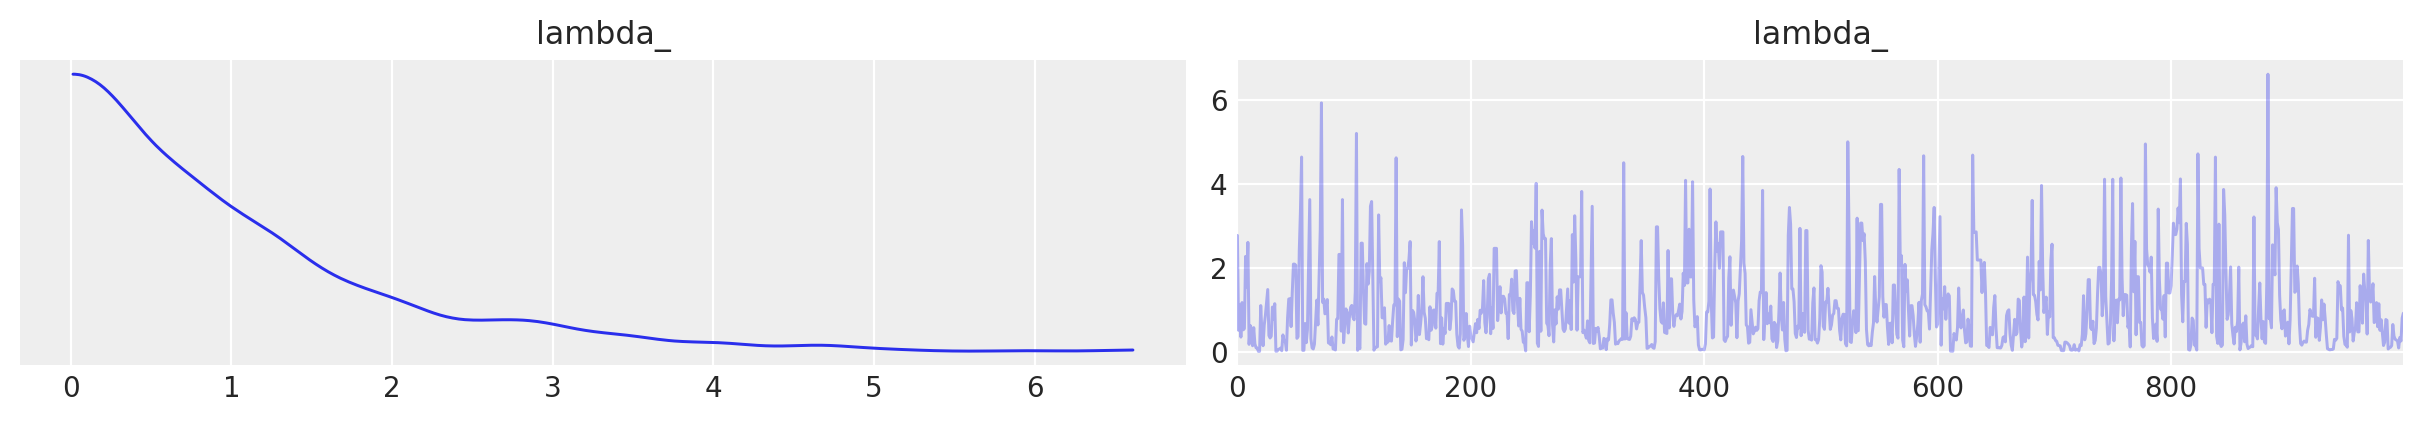

In [7]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata);

### 観測データのベイズ的なモデリングの例
* データモデルとして用意したベイズ的な確率モデルを、与えられた観測データに当てはめてみる例を、下に示す。

* ベイズ的なモデリングでは、最尤推定やMAP推定のように、モデルのパラメータの値を決め打ちで求めるのではない。
* パラメータ$\theta$の条件付き確率分布である、事後分布$P(\theta|X)$を求める。
 * 事後分布は、観測データ$X$を所与とする、条件付き確率分布になっている。
 * もちろん、事前分布$P(\theta)$をあらかじめ設定しておく必要がある。

* 下のモデルは、まず、平均パラメータが0で標準偏差パラメータが0.5の正規分布に従う、unobservedな確率変数`mu`を持っている。
 * この正規分布は、モデルパラメータ$\mu$が従う、事前分布である。
* そして、平均パラメータが確率変数`mu`で、標準偏差パラメータが1である正規分布に従う、observedな確率変数`obs`を持っている。
 * この正規分布は、データを直接モデリングする、確率分布である。
* 観測データとしては、人工的に作ったデータを使っている。
 * ここでは、100個の標準正規乱数を使っている。

In [8]:
rng_key, rng_key_ = random.split(rng_key)
observed = jax.random.normal(rng_key_, (100,))

def model(data=None):
  mu = numpyro.sample("mu", dist.Normal(0, 0.5))
  obs = numpyro.sample("obs", dist.Normal(mu, 1), obs=data)

* いま定義したモデルを数式で書くと、以下のようになる。
$$ \mu \sim N(0, 0.5) $$
$$ x \sim N(\mu, 1) $$


* MCMCを使い、モデルをデータにフィットさせる。
 * つまり、事後分布からのサンプルを得る。

In [9]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, data=observed)

<ipython-input-9-7c585fd3c566>:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2137.63it/s, 3 steps of size 1.01e+00. acc. prob=0.93]


In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.01      0.10      0.01     -0.15      0.17    651.55      1.01

Number of divergences: 0


* warm upを長くしてみる。
 * 結果はどのように変化するだろうか？

In [11]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=1000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, data=observed)

<ipython-input-11-d53b1f502fec>:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=4000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 5000/5000 [00:03<00:00, 1456.16it/s, 3 steps of size 1.15e+00. acc. prob=0.89]


In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.00      0.10     -0.00     -0.16      0.17    734.37      1.00

Number of divergences: 0


* ArviZでサンプルを可視化する。

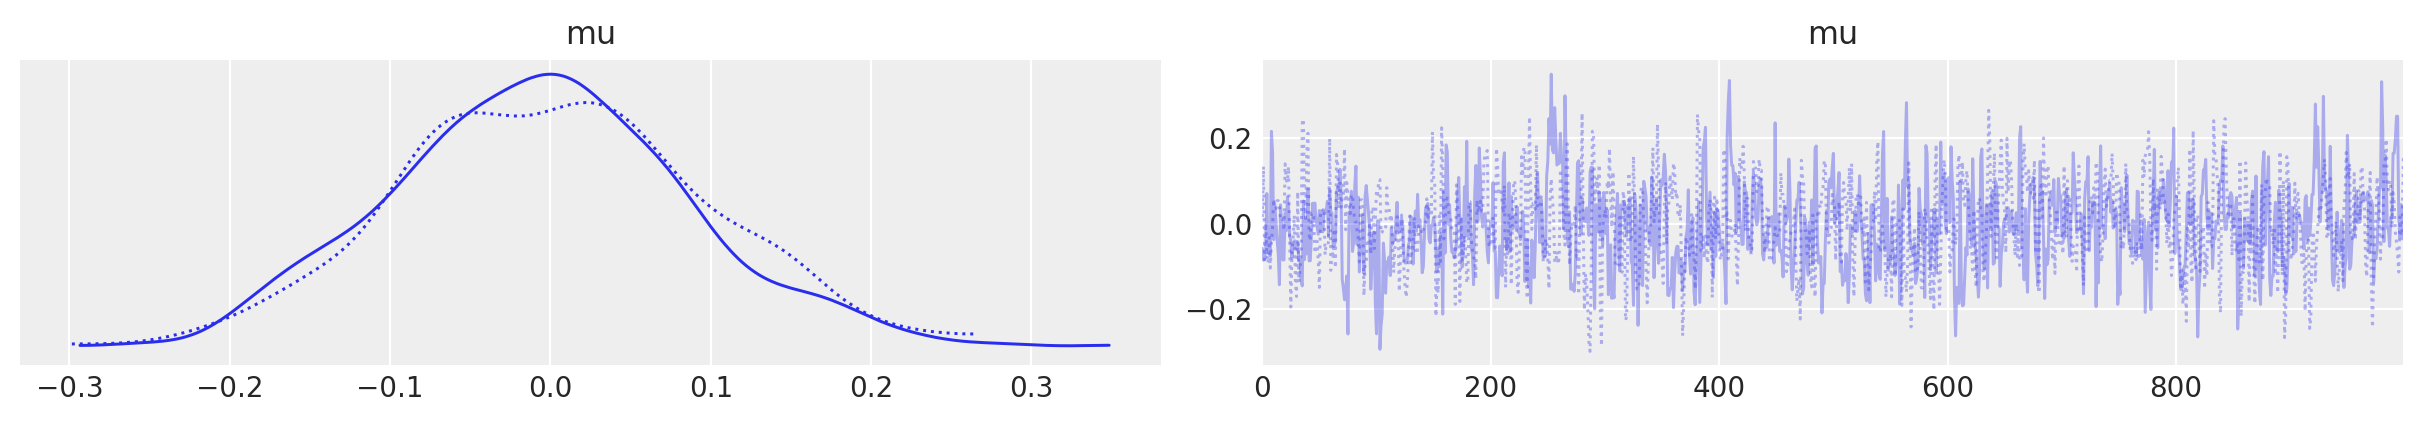

In [13]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata);

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.003,0.098,-0.19,0.176,0.004,0.003,743.0,995.0,1.0


* 観測データの平均を見てみる。

In [ ]:
observed.mean()

* モデルのgraphical representationを得ることもできる。
 * Google Colabでは、エラーが出て動かない？

In [ ]:
#numpyro.render_model(model, model_args=(observed,))

## NumPyroで使える確率分布
* https://num.pyro.ai/en/latest/distributions.html

* `help`関数で各分布の説明を見ることができる。

In [ ]:
help(dist.Normal)

## MCMC (Markov Chain Monte Carlo) とは？
* 次回以降、NumPyroで様々な事後分布からのサンプリングを行う前に・・・
* MCMCについて、**だいたいのところ**を理解しておく。
 * 参考資料 https://www.ism.ac.jp/~shiro/papers/2017.05.slides/Iba.pdf

### MCMCの使い道：積分の近似計算
* ベイズ的モデリングで、事後分布を求めてどうするのか。
* 事後分布に関して、$\theta$の関数$f(\theta)$の期待値を計算することが、しばしばある。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta$$
 * 例： $f(\theta)$として、データのモデリングに使っている尤度関数$p(x|\theta)$を持ってくると、上の式は予測分布$p(x|X)$を表す。
$$ E_{p(\theta|X)}[p(x|\theta)] = \int p(x|\theta) p(\theta|X) d\theta = p(x|X)$$
* 期待値$E_{p(\theta|X)}[f(\theta)]$のこの計算を、以下の平均値で近似することを、モンテカルロ近似と呼ぶ。
 * $\{ \theta_s \}$は、事後分布$p(\theta|X)$からdrawした$S$個のサンプルを表す。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta \approx \frac{1}{S} \sum_{s=1}^S f(\theta_s) $$

* こういう近似計算をするとき、$p(\theta|X)$からのサンプルが必要。
* そこで、MCMCを使う。

### マルコフ連鎖
* マルコフ連鎖とは、確率変数の列$X_1, X_2, \ldots$で、以下を満たすもののことを言う。
$$P(X_{t+1} = x | X_t=x_t, \ldots, X_1=x_1) = P(X_{t+1}=x | X_t=x_t) $$
 * 次の値の出現確率が、直前の値だけに依存する、ということ。
 * 次の値の出現確率$P(X_{t+1}=x | X_t=x_t)$を、以下、$\pi(x_t \rightarrow x)$と書く。
* ところで、マルコフ連鎖は、以下の等式を満たす定常分布$P(x)$を持つことがある。
$$ \sum_{x^\prime} P(x^\prime) \pi( x^\prime \rightarrow x) = P(x)$$
 * いくつかの性質を満たしてはじめて、マルコフ連鎖は定常分布を持つ。 
 * 世界で一番有名な定常分布は、PageRank？


### MCMC（マルコフ連鎖モンテカルロ法）とは？
* MCMCは、定常分布が所望の分布になるようなマルコフ連鎖を作るアルゴリズム。
* 現在の$x_t$から、次の$x_{t+1}$を"賢く"作ると、こうして得られる値の列$\{x_1,\ldots,x_M\}$が、所望の分布からのサンプルになっている。
* 実際には、最初の数百個〜数千個のサンプルは捨てる。（捨てる期間を[burn-in](https://www.johndcook.com/blog/2016/01/25/mcmc-burn-in/) periodと呼ぶ。）
 * 最初の方のサンプルは、高確率な領域からのサンプルになっていない。

### 詳細釣り合い条件
$$ P(x) \pi (x \rightarrow x^\prime) = P(x^\prime) \pi (x^\prime \rightarrow x)$$
* 上の式は、詳細釣り合い条件、あるいは、可逆性条件と呼ばれる。
* 詳細釣り合い条件は、$\pi$で表されるマルコフ連鎖の定常分布が$P(x)$になるための、**十分条件**。
 * 詳細釣り合い条件無しのMCMCもありうる（cf. https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.105.120603 ）。


## メトロポリス法
* メトロポリス法は、詳細釣り合い条件を満たすような$\pi$を得る一つの方法。

### メトロポリス法のアルゴリズム







1.   今の$x$の次にくる値の候補$x^{new}$を、対称な提案分布$Q(x, x^{new})$に従って生成。
2.   一様乱数$0 \leq r < 1$を発生させる。
3.   $r < \frac{P(x^{new})}{P(x)}$ならば、$x$を$x^{new}$で置き換える。そうでなければ、次の値も今の値と同じ$x$にする。

* ただし、提案分布$Q$が対称とは、$Q(x, x^\prime) = Q(x^\prime, x)$が満たされることをいう。
* $\frac{P(x^{new})}{P(x)}$という比は、分布$P$の密度関数が分かっていなくても、密度関数に比例する関数が分かっていれば、計算できる。

### メトロポリス法が詳細釣り合い条件を満たすことの証明

* $x$がとりうる２つの値、$\alpha$および$\gamma$を考える。
* 一般性を失うことなく、$P(\alpha) < P(\gamma)$を仮定する。
* 今の値が$\alpha$で、次の値の候補が$\gamma$であるとき、$1 < \frac{P(\gamma)}{P(\alpha)}$となり、一様乱数の値$r$が何であっても必ず$r < \frac{P(\gamma)}{P(\alpha)}$が満たされる。つまり、候補$\gamma$は$r$の値によらず採用される。よって、$\alpha$から$\gamma$へ遷移する確率$\pi(\alpha \to \gamma)$は、$Q(\alpha, \gamma)$に一致する。
* 今の値が$\gamma$で、次の値の候補が$\alpha$であるときは、$r < \frac{P(\alpha)}{P(\gamma)}$が成り立たなければ$\alpha$は採用されない。よって、$\gamma$から$\alpha$へ遷移する確率$\pi(\gamma \to \alpha)$は、$Q(\gamma, \alpha) \times \frac{P(\alpha)}{P(\gamma)}$に一致する。
* 詳細釣り合い条件において等式で結ばれている両辺のうち、今の値が$\alpha$である場合に対応するほうは、$P(\alpha)\pi(\alpha \to \gamma)$であり、これは、$P(\alpha)Q(\alpha, \gamma)$となる。
* 詳細釣り合い条件において等式で結ばれている両辺のうち、今の値が$\gamma$である場合に対応するほうは、$P(\gamma)\pi(\gamma \to \alpha)$であり、これは、$P(\gamma)Q(\gamma, \alpha) \times \frac{P(\alpha)}{P(\gamma)} = P(\alpha) Q(\gamma, \alpha)$となる。
* 提案分布$Q$は対称だったので、これら両辺は等しくなる。

* 以上の議論により、メトロポリス法で得られる$x$の列は、確率分布$P$からのサンプルの列と見なすことができる。

* メトロポリス法は、次の値の候補$x^{new}$が採用されないと、前に進まない。
* つまり、選んだ提案分布が不味くて、いくら候補をそこから生成させてもほとんどが採用されないと、いくら時間をかけても少ししかサンプルが得られない。
* 良い提案分布を選ぶことが重要である！

## メトロポリス・ヘイスティングス法
* MH法では、非対称な提案分布も使える。
 * よって、メトロポリス法はMH法の特殊ケースだと言える。

### メトロポリス・ヘイスティングス法のアルゴリズム 


1.   今の$x$の次にくる値の候補$x^{new}$を、提案分布$Q(x, x^{new})$に従って生成。
2.   一様乱数$0 \leq r < 1$を発生させる。
3.   $r < A(x,x^{new})$ならば、$x$を$x^{new}$で置き換える。そうでなければ、次の値も今の値と同じ$x$にする。ただし、$A(x,x^{new})$は以下のように定義される：

$$ A(x,x^{new}) \equiv \min \bigg(1, \frac{P(x^{new})Q(x^{new}, x)}{P(x) Q(x, x^{new})} \bigg) $$

# 課題２
* 今回は、以下のモデルについて、事後分布からサンプルを得た。
$$ \mu \sim N(0, 0.5) $$
$$ x \sim N(\mu, 1) $$
* しかし、事前分布が共役であるため、このモデルについては手計算でも事後分布を計算できる。
* そこで、$\mu$が従う事後分布の密度関数を計算し、`arviz.plot_trace()`による可視化がその関数に近い形になっていたか、確認してみよう。